In [1]:
import zipfile
import pandas as pd
import numpy as np
from PIL import Image
import io
# List of paths to your zip files 
# The four zip files should be:
# 1. inpainting.zip
# 2. insight.zip
# 3. text2img.zip
# 4. wiki.zip (contains real images)

#Make sure you do not commit the data to the repository
#Also make sure to not upload your paths to the repository


zip_paths = [
    '../mle_group_6_data/inpainting.zip',
    '../mle_group_6_data/insight.zip',
    '../mle_group_6_data/text2img.zip',
    '../mle_group_6_data/wiki.zip'
]




# Function to add image data to a DataFrame from multiple zip files
def create_image_dataframe(zip_paths, base_num_images_per_zip=1000):
    # List to store image data
    data = []

    # Process each zip file
    for zip_path in zip_paths:
        print(f"Processing zip file: {zip_path}")  # Print current zip file being processed

        # Determine number of images to process based on zip file name
        if 'wiki.zip' in zip_path:
            num_images_per_zip = base_num_images_per_zip * 3
        else:
            num_images_per_zip = base_num_images_per_zip

        with zipfile.ZipFile(zip_path, 'r') as z:
            image_count = 0  # Initialize image counter for the current zip file

            # Iterate over each item in the zip
            for file in sorted(z.namelist()):
                if file.endswith(('.png', '.jpg', '.jpeg')) and '/' in file:
                    # Read the image
                    image_data = z.read(file)
                    image = Image.open(io.BytesIO(image_data))

                    # Convert image to grayscale and resize
                    image = image.convert('RGB').resize((128, 128), Image.LANCZOS)
                    img_array = np.array(image)

                    # Determine if the image is a deepfake or not based on the zip file
                    is_deep_fake = not zip_path.endswith('wiki.zip')

                    # Append image information to the list
                    data.append({
                        'Zip Folder': zip_path,
                        'Image Path': file,
                        'Is DeepFake': is_deep_fake,
                        'Image Data': img_array.flatten()  # Flatten the array
                    })

                    image_count += 1
                    if image_count >= num_images_per_zip:
                        break  # Stop processing if the image limit is reached
                else:
                    print(file)

    # Convert list to DataFrame
    df = pd.DataFrame(data)
    return df

# Call the function and store the DataFrame
df_images = create_image_dataframe(zip_paths)

Processing zip file: ../mle_group_6_data/inpainting.zip
inpainting/
inpainting/00/
inpainting/01/
inpainting/02/
inpainting/03/
Processing zip file: ../mle_group_6_data/insight.zip
insight/
insight/00/
insight/01/
insight/02/
insight/03/
Processing zip file: ../mle_group_6_data/text2img.zip
text2img/
text2img/00/
text2img/01/
text2img/02/
text2img/03/
Processing zip file: ../mle_group_6_data/wiki.zip
wiki/
wiki/00/
wiki/01/
wiki/02/
wiki/03/
wiki/04/
wiki/05/
wiki/06/
wiki/07/
wiki/08/
wiki/09/
wiki/10/


In [2]:
image_counts = df_images['Zip Folder'].value_counts()
dataset_size = 0
for count in image_counts:
    dataset_size = dataset_size + count
print (dataset_size)
print("\nNumber of images from each zip folder:")
print(image_counts)

6000

Number of images from each zip folder:
Zip Folder
../mle_group_6_data/wiki.zip          3000
../mle_group_6_data/inpainting.zip    1000
../mle_group_6_data/insight.zip       1000
../mle_group_6_data/text2img.zip      1000
Name: count, dtype: int64


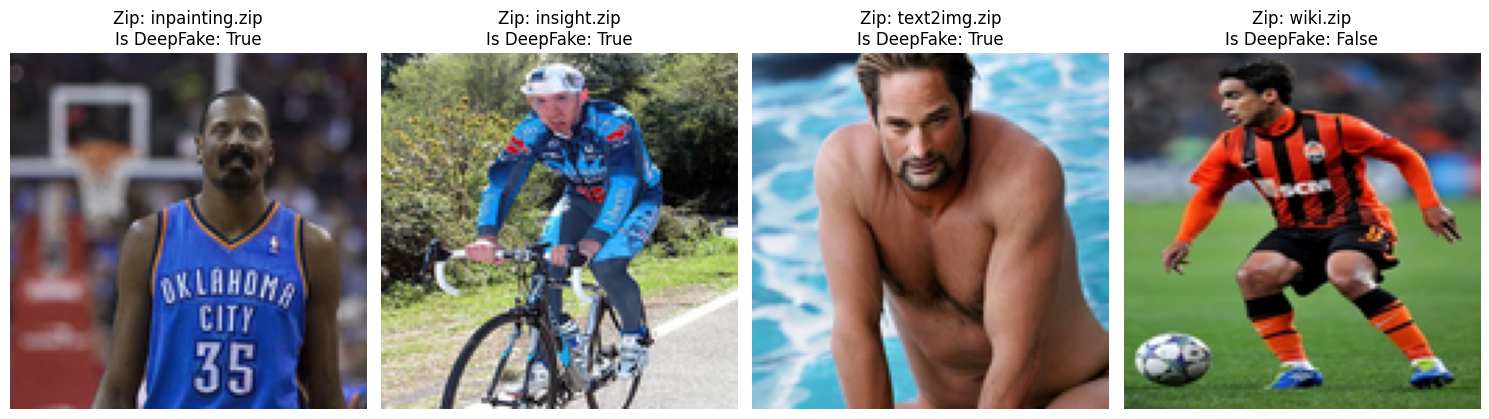

In [3]:
import matplotlib.pyplot as plt
import random

def display_random_images_from_each_zip(df_images):
    # Find unique zip folders
    unique_zip_folders = df_images['Zip Folder'].unique()

    fig, axes = plt.subplots(1, len(unique_zip_folders), figsize=(15, 5))

    # Loop through each unique zip folder
    for i, zip_folder in enumerate(unique_zip_folders):
        # Filter the DataFrame for images only from the current zip folder
        folder_images = df_images[df_images['Zip Folder'] == zip_folder]
        
        # Select a random image from this folder
        random_index = random.randint(0, len(folder_images) - 1)
        image_row = folder_images.iloc[random_index]
        image_data = image_row['Image Data'].reshape(128, 128, 3)  # Reshape the flattened array back to 128x128
        is_deep_fake = image_row['Is DeepFake']  # Retrieve the 'Is DeepFake' status correctly from the row

        # Plot the image
        ax = axes[i] if len(unique_zip_folders) > 1 else axes
        ax.imshow(image_data, cmap='gray')
        ax.axis('off')  # Turn off axis
        ax.set_title(f"Zip: {zip_folder.split('/')[-1]}\nIs DeepFake: {is_deep_fake}")


    plt.tight_layout()
    plt.show()

# Call the function to display the images
display_random_images_from_each_zip(df_images)


In [8]:
import numpy as np
import tensorflow as tf

def prepare_data_for_cnn(df_images):
    # Convert flattened images to 2D shape and expand dimensions to include the channel
    # This lambda function assumes each row in 'Image Data' is a flattened image of 128x128 pixels
    images = np.stack(df_images['Image Data'].apply(lambda x: np.reshape(x, (128, 128, 3))))

    # Normalize the images to have values between 0 and 1
    #images = images.astype('float32') / 255.0

    # Extract labels and convert them to integer format
    labels = df_images['Is DeepFake'].values.astype('int')

    return images, labels

# Assuming df_images is your DataFrame containing the required image data
images, labels = prepare_data_for_cnn(df_images)

# Create a TensorFlow dataset from the numpy arrays
dataset = tf.data.Dataset.from_tensor_slices((images, labels))
dataset_size = len(labels)  # Define the dataset size based on the labels array

# Shuffle the entire dataset before splitting (important for randomness)
dataset = dataset.shuffle(buffer_size=1000)

# Calculate the size of each dataset part
train_size = int(0.6 * dataset_size)
val_size = int(0.2 * dataset_size)
test_size = int(0.2 * dataset_size)  # Adjust to make sure the sizes sum up to dataset_size

# Split the dataset into training, validation, and testing
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size).take(test_size)
val_dataset = dataset.skip(train_size + test_size)  # Ensure correct skipping

# Batch the datasets
train_dataset = train_dataset.batch(32)
test_dataset = test_dataset.batch(32)
val_dataset = val_dataset.batch(32)

# Print dataset cardinalities to confirm sizes
print("Training set size:", train_dataset.cardinality().numpy())
print("Test set size:", test_dataset.cardinality().numpy())
print("Validation set size:", val_dataset.cardinality().numpy())


# Take one batch from the dataset and print shapes
for images_batch, labels_batch in dataset.take(1):
    print("Images shape:", images_batch.shape)  # Expected shape: (batch_size, 128, 128, 1)
    print("Labels shape:", labels_batch.shape)  # Expected shape: (batch_size,)


Training set size: 113
Test set size: 38
Validation set size: 38
Images shape: (128, 128, 3)
Labels shape: ()


In [18]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.applications import MobileNetV2
#highest accuracy so far is 0.9617 

base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False
l2_reg = 0.01

# Create the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg)),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(l2_reg))
])

# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [19]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=val_dataset
)

Epoch 1/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 34s 158ms/step - accuracy: 0.8593 - loss: 1.3733 - val_accuracy: 0.9492 - val_loss: 0.3821
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 30s 160ms/step - accuracy: 0.7440 - loss: 0.7205 - val_accuracy: 0.9583 - val_loss: 0.2455
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 148ms/step - accuracy: 0.7329 - loss: 0.7296 - val_accuracy: 0.9600 - val_loss: 0.2377
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.7399 - loss: 0.6686 - val_accuracy: 0.9550 - val_loss: 0.2980
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 28s 149ms/step - accuracy: 0.6838 - loss: 0.6696 - val_accuracy: 0.9492 - val_loss: 0.3125
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 155ms/step - accuracy: 0.4892 - loss: 0.7774 - val_accuracy: 0.9517 - val_loss: 0.2657
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 29s 153ms/step - accuracy: 0.6011 - loss: 0.7249 - val_accuracy: 0.9492 - val_loss: 0.6019
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 31s 166ms/step - accuracy: 0.3994 - loss: 0